# Programming assignment 09: Deep Learning CNN

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from IPython.display import clear_output
import scipy

## Your Task

In this notebook, the skeleton for learning a feed-forward neural network is given. Your task is to complete the functions where required.

## Submission

**Submit your notebook by January 6, 2019** as a .html file with your code and the respective cell outputs.

You can also take part in our challenge to fit the best model to the cell phone data by submitting your predictions for the test data. The winners of the challenge will be announced after the Christmas break! See the bottom of this file for more information.

## Load and Preprocess Data

I this assignment we will work with a dataset containing accelerometer and gyroscope sensor signals of a cell-phone. Given the sensor signals, the task is to predict the activity that the cell-phone user is doing, e.g, running, walking, biking, or moving upstairs.

The data consists of 8032 samples. Each feature vector contains 6 measurements from the cell-phone sensors in 20 consequent time steps. Indeed, each feature vector is 120-dimensional. The task is to classify these instances into the following classes: "Walking", "Standing", "Sitting", "Running", "Upstairs", "Downstairs".

More details can be found here: https://becominghuman.ai/deep-learning-for-sensor-based-human-activity-recognition-970ff47c6b6b 

**Before you start** download the data from https://syncandshare.lrz.de/dl/fiXnRq4MRd8fGJBXH2jQmNcN/homework_09_data.npz and place the file into the same directory as this notebook.

In [4]:
# Normalize (between [0,1])? or standardize(mean=0, std=1)? for cnn data
def standardize(train, test):
    """ Standardize data """
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
    X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

    return X_train, X_test

In [6]:
loader = np.load("homework_09_data.npz")
train_data = loader['train_data'] # 4819
train_labels = loader['train_labels']

val_data = loader['val_data'] # 1606
val_labels = loader['val_labels']

test_data = loader['test_data'] # 1607

## preprocessing

# reshape for Convolutions data_dim -> [seq_len, n_channels]
train_data = train_data.reshape((-1,20,6))
val_data = val_data.reshape((-1,20,6))
test_data = test_data.reshape((-1,20,6))

# standardize
train_data, val_data = standardize(train_data, val_data)
_, test_data = standardize(train_data, test_data)

# for kfold cross validation
train_data = np.append(train_data, val_data, axis = 0)
train_labels = np.append(train_labels, val_labels, axis = 0)

In [7]:
train_data.shape

(6425, 20, 6)

No handles with labels found to put in legend.


[0.19434567 0.1796083 ]
[387.09232 372.12625]


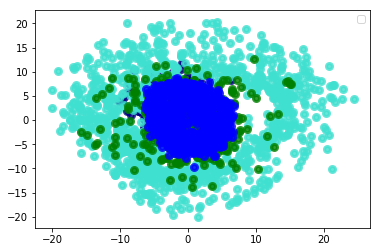

In [5]:
# pca
dat = train_data.reshape((-1,120))
pca = PCA(n_components=2)
X_r=pca.fit(dat).transform(dat)
y = np.array([np.where(r==1)[0][0] for r in train_labels])

plt.figure()
colors = ['navy', 'turquoise', 'darkorange','r','g','b']
lw = 3

for color, i in zip(colors, [0, 1, 2,3,4,5]):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw)
plt.legend(loc='best', shadow=False, scatterpoints=1)

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  


The skeleton of the class ```FeedForwardNet``` is provided in the following. This class implements a feed-forward neural network in Tensorflow. 
**Your task** is to complete the parts where it says ```### YOUR CODE HERE ###```. 

To complete the code properly, make sure that you make the computation graph based on the placeholders ```self.X``` and ```self.Y```. These two placeholders are created in the `build` function; you don't need to create them. You only need to use them.
* ```self.X```: a placeholder of shape ```[None,D]``` where the none dimension will be replaced by the number of instances, and $D$ is number of features.
* ```self.Y```: a placeholder of shape ```[None,K]``` where the none dimension will be replaced by the number of instances, and $K$ is number of classes.



# Convolutional Network

In [8]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs
    

class CNN:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, name,learning_rate=0.001, l2_reg=0.0):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.name = name
        self.learning_rate = learning_rate
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.l2_reg = l2_reg
        self.weights =[]
        self.biases =[]
        
        
    def make_plot(self):
        train_acc_dropoutreg = self.hist['train_accuracy'][-1]
        val_acc_dropoutreg = self.hist['val_accuracy'][-1]

        print("dr:",f"{train_acc_dropoutreg:.3f}",f"{val_acc_dropoutreg:.3f}")

        print(epochs, batch_size, learning_rate)
        print("maxacc,minloss at epoch: ", np.argmax(self.hist['val_accuracy']),np.argmin(self.hist['val_loss']),\
              "acc there: ", self.hist['val_accuracy'][np.argmax(self.hist['val_accuracy'])],\
             self.hist['val_accuracy'][np.argmin(self.hist['val_loss'])])

        plt.figure(figsize=(10,5))

        plt.plot(self.hist['train_loss'][0::], 
                 label="Training Loss (dropout regularization)")
        plt.plot(self.hist['val_loss'][0::], 
                 label="Validation Loss (dropout regularization)", linestyle="--")
        
        plt.plot(self.hist['train_accuracy'][0::], 
                 label="Training Acc (dropout regularization)", color="purple")
        plt.plot(self.hist['val_accuracy'][0::], 
                 label="Validation Acc (dropout regularization)", color="purple", linestyle="--")

        plt.xlabel("Epoch", fontsize=20)
        plt.ylabel("Loss & Acc", fontsize=20)
        plt.legend()
        plt.show()
    
    def build(self, seq_len, num_channels, num_classes):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X = tf.placeholder(shape=[None, seq_len, num_channels], dtype=tf.float32, name="data") #[NxD]
        self.Y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name="labels") #[Nx1]
    
        with tf.variable_scope(self.name):
        
            hidden = self.X
            
            # 20 -> 10
            hidden = tf.layers.conv1d(inputs=hidden, filters=16, kernel_size=2, strides=1, padding='same', activation = tf.nn.relu)
            hidden = tf.layers.max_pooling1d(inputs=hidden, pool_size=2, strides=2, padding='same')

            # 10 -> 5
            hidden = tf.layers.conv1d(inputs=hidden, filters=32, kernel_size=2, strides=1, padding='same', activation = tf.nn.relu)
            hidden = tf.layers.max_pooling1d(inputs=hidden, pool_size=2, strides=2, padding='same')

            # 5 -> 3
            hidden = tf.layers.conv1d(inputs=hidden, filters=64, kernel_size=2, strides=1, padding='same', activation = tf.nn.relu)
            hidden = tf.layers.max_pooling1d(inputs=hidden, pool_size=2, strides=2, padding='same')
        
            # 3 -> 2
            hidden = tf.layers.conv1d(inputs=hidden, filters=128, kernel_size=2, strides=1,padding='same', activation = tf.nn.relu)
            hidden = tf.layers.max_pooling1d(inputs=hidden, pool_size=2, strides=2, padding='same')

            hidden = tf.reshape(hidden, (-1, 2*128))
            hidden = tf.nn.dropout(hidden, 1-self.dropout)

            hidden = tf.layers.dense(hidden, 128, activation=tf.nn.relu)
            hidden = tf.nn.dropout(hidden, 1-self.dropout)
            
            self.logits = tf.layers.dense(hidden, num_classes)

            self.cross_entropy_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits,labels=self.Y,name="cross_entropy_loss"))
            
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.logits > 0, tf.cast(self.Y, tf.bool)),tf.float32), name="accuracy")
            
            self.loss = self.cross_entropy_loss
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
            
        
    def train(self, session, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        self.dropout = dropout
        

        self.session = session
        
        with session.as_default():
            session.run(tf.global_variables_initializer())
            
            tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
            val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
                        
            for epoch in range(epochs):
                if (epoch + 1) % 10 == 0:
                    #clear_output()
                    print(f"Epoch {epoch+1}/{epochs}")
                    self.make_plot()
                for batch_ixs in batch_data(len(train_data), batch_size):
                    _ = session.run( self.optimizer, feed_dict={self.X: train_data[batch_ixs], self.Y: train_labels[batch_ixs]})
                    
                tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
                val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                train_losses.append(tr_loss)
                train_accs.append(tr_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)    

                
                self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs)}
                

## KFold CrossValidation

In [9]:
# Params
epochs = 50
batch_size = 64
learning_rate = 0.001


Epoch 10/50
dr: 0.985 0.977
50 64 0.001
maxacc,minloss at epoch:  9 9 acc there:  0.97731984 0.97731984


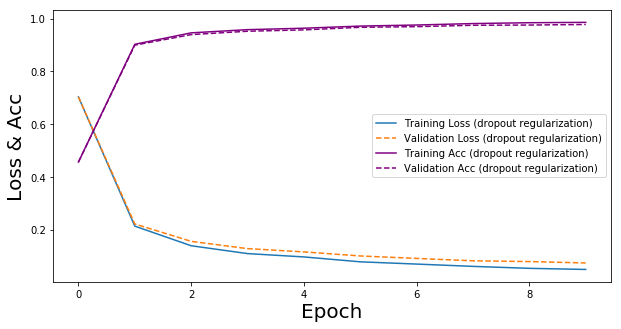

Epoch 20/50
dr: 0.993 0.982
50 64 0.001
maxacc,minloss at epoch:  16 17 acc there:  0.9835407 0.9832815


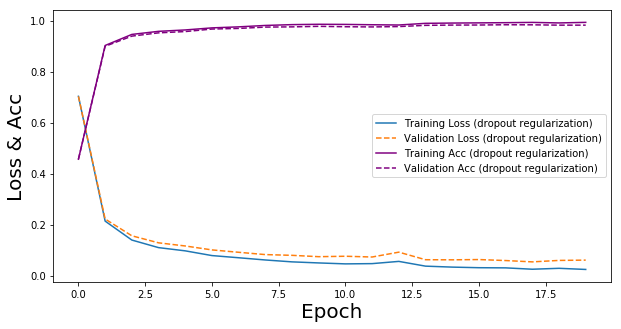

Epoch 30/50
dr: 0.996 0.986
50 64 0.001
maxacc,minloss at epoch:  21 21 acc there:  0.9860031 0.9860031


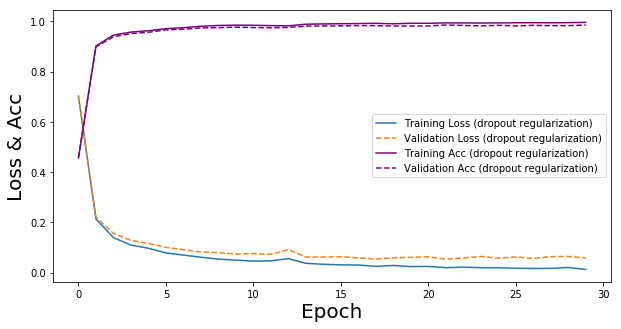

Epoch 40/50
dr: 0.997 0.985
50 64 0.001
maxacc,minloss at epoch:  33 21 acc there:  0.9862623 0.9860031


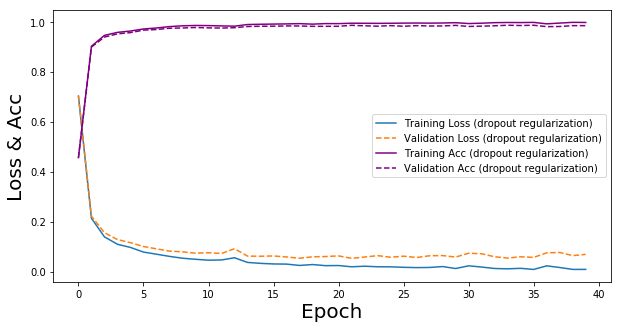

Epoch 50/50
dr: 0.999 0.985
50 64 0.001
maxacc,minloss at epoch:  40 21 acc there:  0.9866511 0.9860031


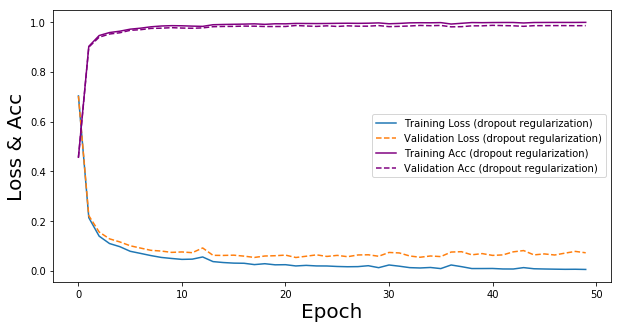

Epoch 10/50
dr: 0.979 0.973
50 64 0.001
maxacc,minloss at epoch:  8 8 acc there:  0.97887504 0.97887504


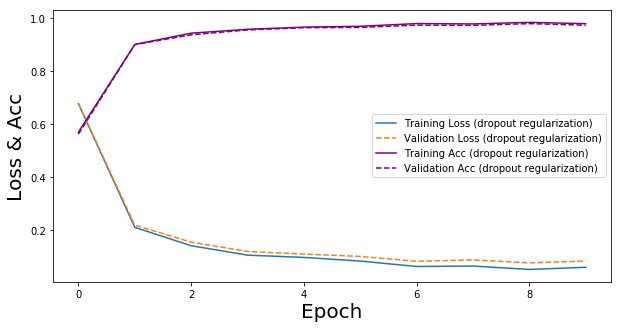

Epoch 20/50
dr: 0.990 0.979
50 64 0.001
maxacc,minloss at epoch:  17 17 acc there:  0.98185587 0.98185587


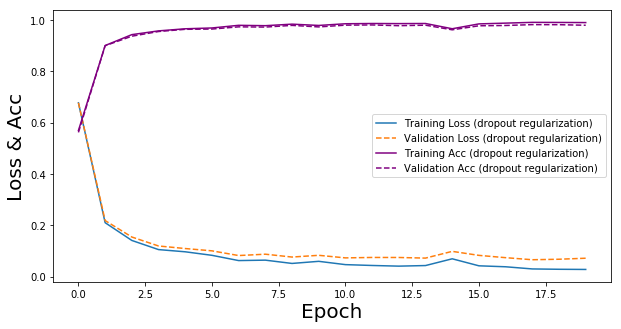

Epoch 30/50
dr: 0.995 0.983
50 64 0.001
maxacc,minloss at epoch:  26 25 acc there:  0.9834111 0.9832815


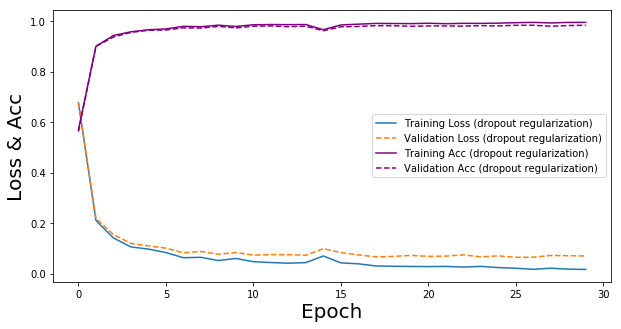

Epoch 40/50
dr: 0.997 0.985
50 64 0.001
maxacc,minloss at epoch:  38 36 acc there:  0.9860031 0.9849663


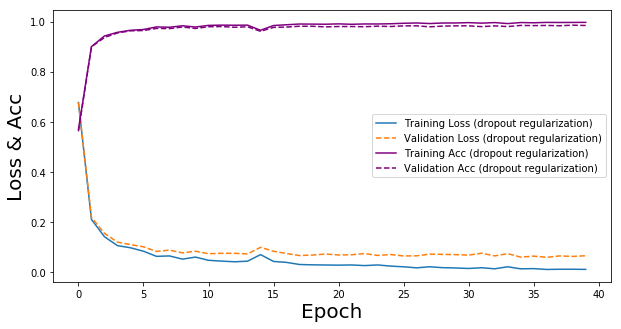

Epoch 50/50
dr: 0.997 0.984
50 64 0.001
maxacc,minloss at epoch:  38 36 acc there:  0.9860031 0.9849663


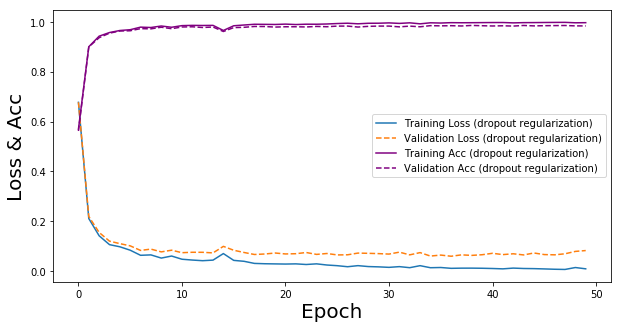

Epoch 10/50
dr: 0.985 0.982
50 64 0.001
maxacc,minloss at epoch:  9 9 acc there:  0.98158234 0.98158234


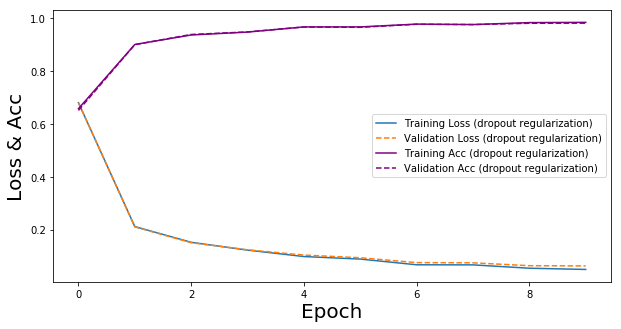

Epoch 20/50
dr: 0.993 0.986
50 64 0.001
maxacc,minloss at epoch:  18 19 acc there:  0.98664075 0.9858625


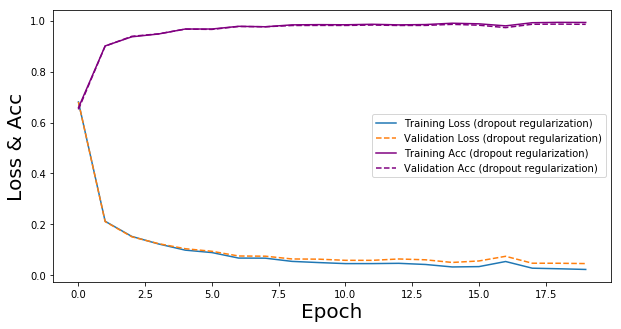

Epoch 30/50
dr: 0.996 0.985
50 64 0.001
maxacc,minloss at epoch:  18 19 acc there:  0.98664075 0.9858625


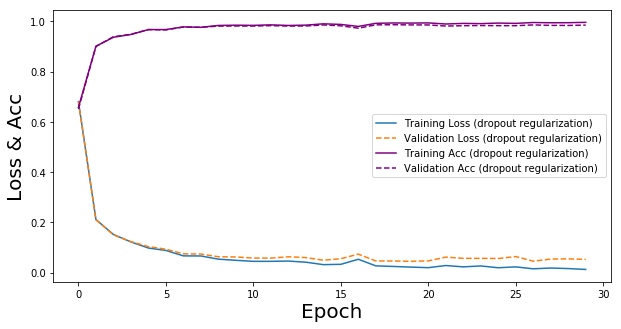

Epoch 40/50
dr: 0.998 0.986
50 64 0.001
maxacc,minloss at epoch:  18 19 acc there:  0.98664075 0.9858625


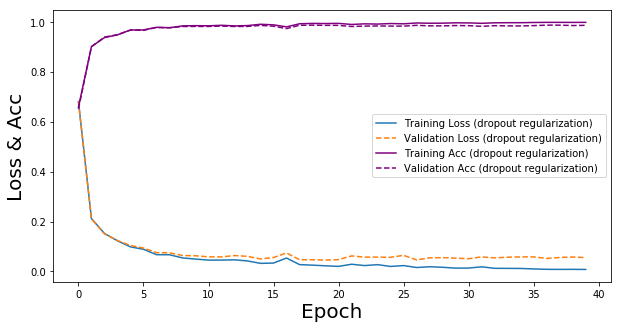

Epoch 50/50
dr: 0.995 0.983
50 64 0.001
maxacc,minloss at epoch:  18 19 acc there:  0.98664075 0.9858625


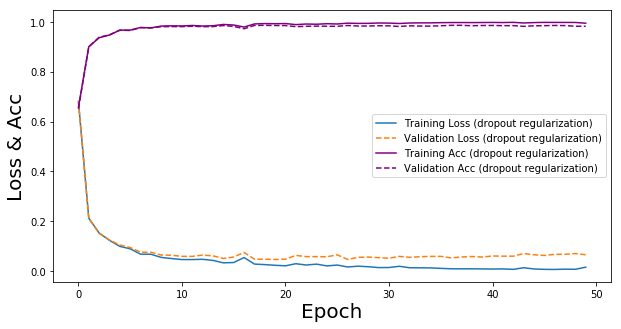

Epoch 10/50
dr: 0.983 0.978
50 64 0.001
maxacc,minloss at epoch:  8 8 acc there:  0.97898835 0.97898835


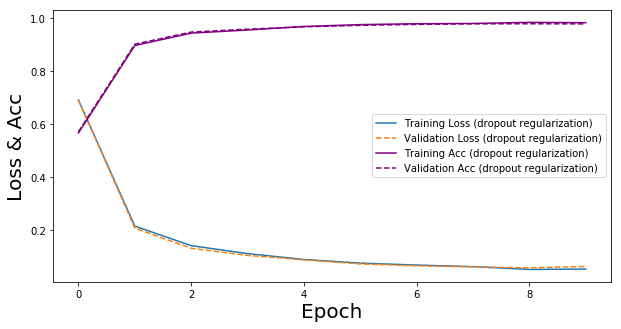

Epoch 20/50
dr: 0.992 0.983
50 64 0.001
maxacc,minloss at epoch:  14 14 acc there:  0.9849546 0.9849546


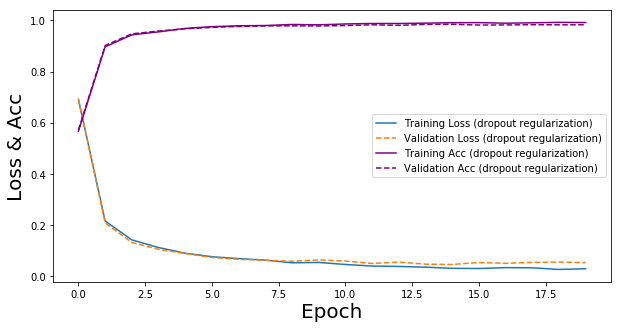

Epoch 30/50
dr: 0.997 0.987
50 64 0.001
maxacc,minloss at epoch:  29 14 acc there:  0.98677045 0.9849546


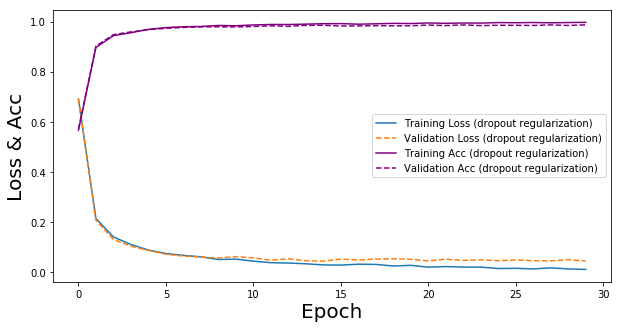

Epoch 40/50
dr: 0.997 0.986
50 64 0.001
maxacc,minloss at epoch:  29 14 acc there:  0.98677045 0.9849546


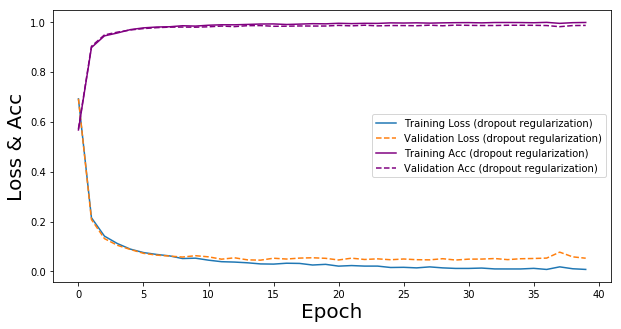

Epoch 50/50
dr: 0.999 0.987
50 64 0.001
maxacc,minloss at epoch:  29 14 acc there:  0.98677045 0.9849546


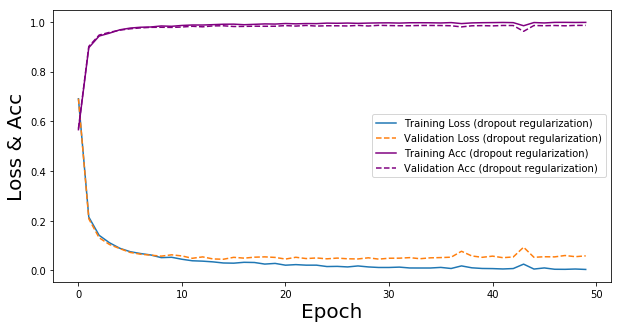

Epoch 10/50
dr: 0.984 0.977
50 64 0.001
maxacc,minloss at epoch:  9 9 acc there:  0.9766173 0.9766173


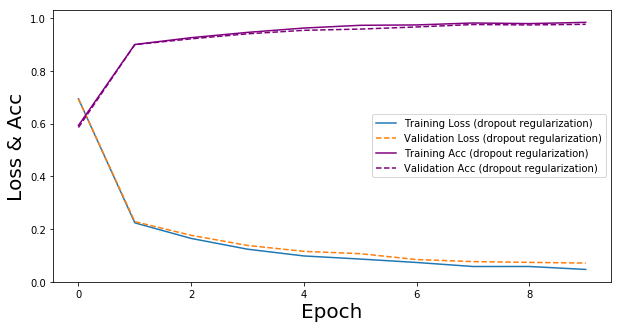

Epoch 20/50
dr: 0.991 0.981
50 64 0.001
maxacc,minloss at epoch:  16 19 acc there:  0.98142374 0.9809041


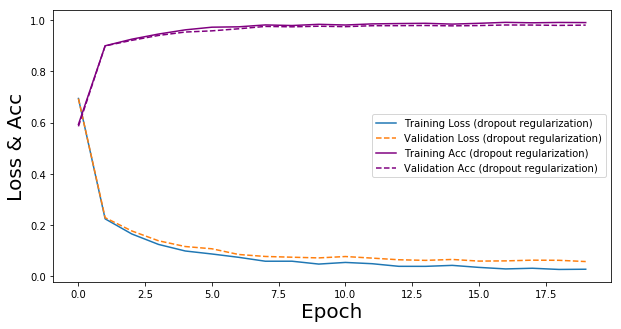

Epoch 30/50
dr: 0.996 0.983
50 64 0.001
maxacc,minloss at epoch:  28 24 acc there:  0.98610026 0.9855807


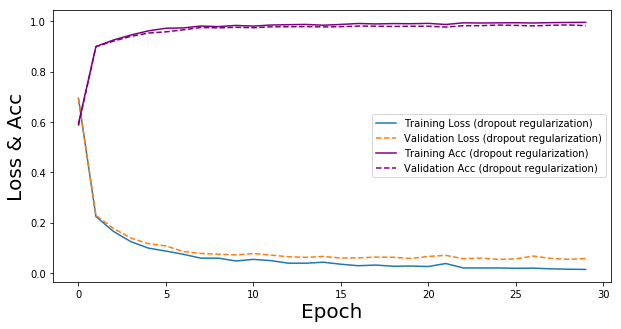

Epoch 40/50
dr: 0.998 0.987
50 64 0.001
maxacc,minloss at epoch:  39 32 acc there:  0.9866199 0.9863601


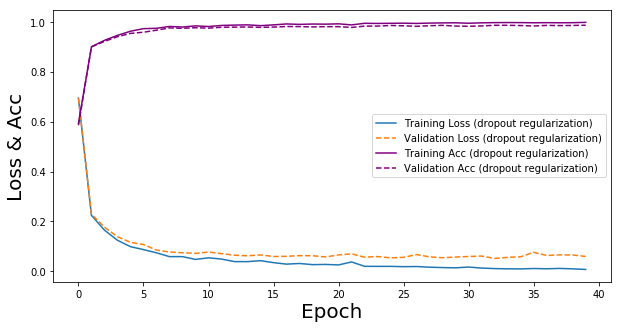

Epoch 50/50
dr: 0.998 0.988
50 64 0.001
maxacc,minloss at epoch:  49 32 acc there:  0.98804885 0.9863601


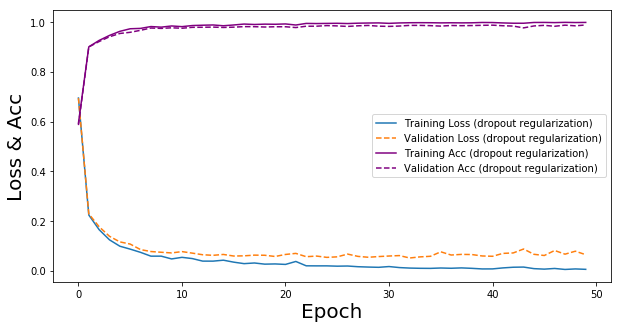

CV-Results.
 0.9868 CV-score (mean of accs at maximum Acc): Single Scores [0.987 0.986 0.987 0.987 0.988] 
 0.9843 CV-score (mean of accs at the end): Single Scores [0.985 0.986 0.984 0.985 0.982] 
 0.9856 CV-score (mean of accs at minimal loss): Single Scores [0.986 0.985 0.986 0.985 0.986] 
Details ['Run 0, lastValAcc: 0.985, maxValAcc: 0.987, maxacc: 0.986', 'Run 1, lastValAcc: 0.986, maxValAcc: 0.986, maxacc: 0.985', 'Run 2, lastValAcc: 0.984, maxValAcc: 0.987, maxacc: 0.986', 'Run 3, lastValAcc: 0.985, maxValAcc: 0.987, maxacc: 0.985', 'Run 4, lastValAcc: 0.982, maxValAcc: 0.988, maxacc: 0.986']


In [9]:
# kfold + stratified
from sklearn.model_selection import StratifiedKFold

def cross_validate(session, split_size=5):
    results, log, maxaccs, maxValAccs, lastValAccs = [], [], [], [], []
    net = CNN("dropout_regularization", learning_rate=learning_rate)
    net.build(train_data.shape[1], train_data.shape[2], num_classes=train_labels.shape[1])
    train_labels_cat = np.array([np.where(r==1)[0][0] for r in train_labels])

    kf = StratifiedKFold(n_splits=split_size)
    for i, (train_idx, val_idx) in enumerate(kf.split(train_data, train_labels_cat)):
        
        net.train(session, train_data[train_idx], train_labels[train_idx], 
                                        train_data[val_idx], train_labels[val_idx], epochs, batch_size=batch_size, dropout=0.5)
        maxacc = net.hist['val_accuracy'][np.argmin(net.hist['val_loss'])]
        lastValAcc = net.hist['val_accuracy'][-1]
        maxValAcc = np.max(net.hist['val_accuracy'])
        
        maxaccs.append(maxacc)
        maxValAccs.append(maxValAcc)
        lastValAccs.append(lastValAcc)
        
        log.append(f"Run {i}, lastValAcc: {lastValAcc:.3f}, maxValAcc: {maxValAcc:.3f}, maxacc: {maxacc:.3f}")
    return maxValAccs, lastValAccs, maxaccs, log
        

# run cv
tf.reset_default_graph()
with tf.Session() as session:
    
    maxValAccs, lastValAccs, maxaccs, log = cross_validate(session)
    print("CV-Results.\n",np.around(np.mean(maxValAccs),4),"CV-score (mean of accs at maximum Acc):","Single Scores",np.around(maxValAccs,3),
          "\n",np.around(np.mean(lastValAccs),4),"CV-score (mean of accs at the end):","Single Scores",np.around(lastValAccs,3),
          "\n",np.around(np.mean(maxaccs),4),"CV-score (mean of accs at minimal loss):","Single Scores",np.around(maxaccs,3),
          "\nDetails",log)

## Challenge

Epoch 10/50
dr: 0.985 0.986
50 64 0.001
maxacc,minloss at epoch:  8 9 acc there:  0.9874429 0.98640513


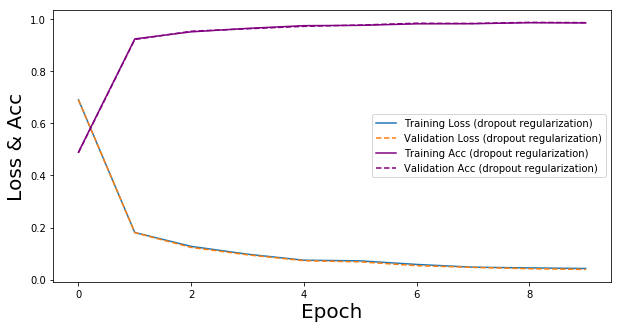

Epoch 20/50
dr: 0.993 0.993
50 64 0.001
maxacc,minloss at epoch:  16 16 acc there:  0.9941885 0.9941885


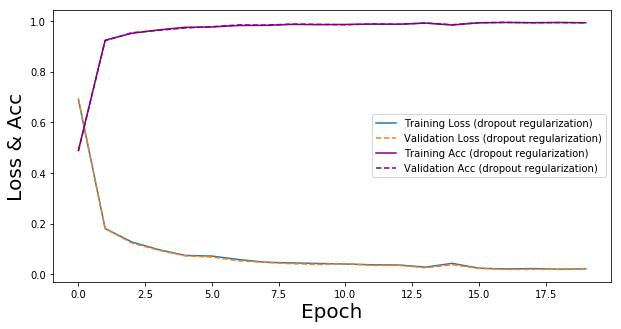

Epoch 30/50
dr: 0.998 0.999
50 64 0.001
maxacc,minloss at epoch:  29 29 acc there:  0.99854714 0.99854714


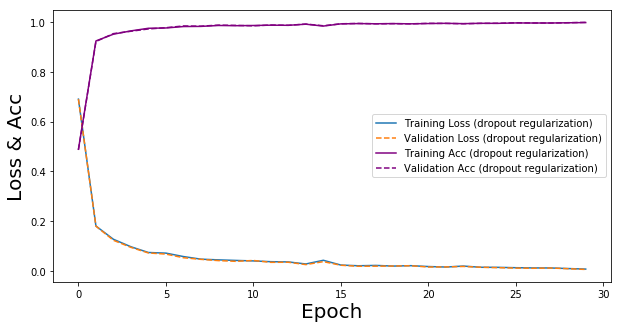

Epoch 40/50
dr: 0.997 0.998
50 64 0.001
maxacc,minloss at epoch:  37 37 acc there:  0.999066 0.999066


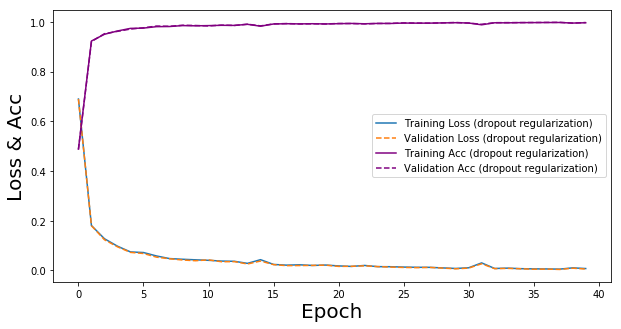

Epoch 50/50
dr: 0.999 0.999
50 64 0.001
maxacc,minloss at epoch:  45 47 acc there:  0.99927354 0.99927354


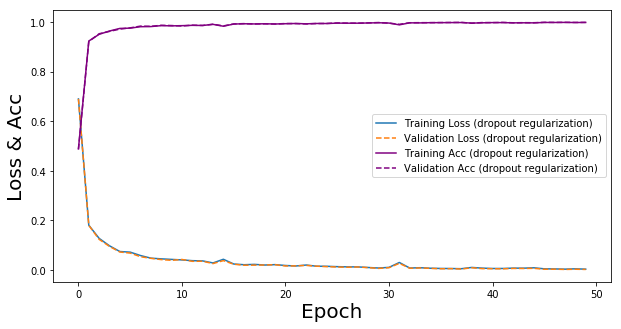

In [12]:
tf.reset_default_graph()
cnn = CNN("dropout_regularization", learning_rate=learning_rate)
cnn.build(train_data.shape[1], train_data.shape[2], num_classes=train_labels.shape[1])
with tf.Session() as session:
    cnn.train(session, train_data, train_labels, val_data, val_labels, epochs, batch_size=batch_size, dropout=0.5)
    test_preds = cnn.logits.eval({cnn.X: test_data}, session=session).argmax(1)

In [13]:
test_preds

array([1, 5, 5, ..., 1, 4, 5])

Notice that we also have the variable `test_data`. **Get creative** and build a model yourself!

Submit your predictions of the test data to Moodle to enter the leaderboard. We will announce the winning team after the Christmas break!

You can output the predictions of the test data using:

In [17]:
test_preds = YOUR_NN_MODEL.logits.eval({YOUR_NN_MODEL.X: test_data},
                                        session=YOUR_NN_MODEL.session).argmax(1)

NameError: name 'YOUR_NN_MODEL' is not defined

We will only consider submission as plain text files with **exactly** the following formatting as our `sample_submission.txt`

In [434]:
string = ""
with open("your_submission.txt", "r") as f:
    string = f.read()
print(string[:19])
print("...")

1
5
5
5
2
0
1
1
5
3
...


You can use the following command to save your predictions:

In [128]:
np.savetxt("cnnBest.txt", test_preds, fmt='%i')